# Week 4

Patrick Weatherford

***


<br>

## Import Modules

Mount Google Drive to Colab session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>Install necessary modules not pre-installed by Colab

In [ ]:
%%capture
!pip install python-Levenshtein
!pip install fuzzywuzzy


<br>Copy custom packages/moduls over to default path where python packages are installed for this Colab session.

In [ ]:
import os
import site
import shutil

# create custom modules folder in default pkg location
dest_path = site.getsitepackages()[0]  # get path where packages are installed
colab_cust_mod_path = f"{dest_path}/hakuna_patata_modules"

if not os.path.exists(colab_cust_mod_path):
    os.makedirs(colab_cust_mod_path)

# create init file in custom modules folder
with open(f"{colab_cust_mod_path}/__init__.py", 'w') as f:
    pass

mods = ['api_keys.py', 'hakuna_patata.py']  # modules to copy over

mod_path = r'/content/drive/MyDrive/Bellevue_University/Python/Custom_Modules'

for mod in mods:
    file_path = f"{mod_path}/{mod}"
    shutil.copy2(file_path, colab_cust_mod_path)


In [ ]:
from hakuna_patata_modules import api_keys, hakuna_patata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from zipfile import ZipFile

from google.colab import data_table
data_table.enable_dataframe_formatter()


***

<br>

## Import Kaggle Dataset

Create Kaggle api object and download the dataset.

In [ ]:
kaggle_user = api_keys.Kaggle_API['username']
kaggle_api_key = api_keys.Kaggle_API['key']

k_api = hakuna_patata.kaggle_api(kaggle_user, kaggle_api_key)

dataset = r'uciml/autompg-dataset'
download_path = r'/content/sample_data'

hakuna_patata.kaggle_dataset_download(k_api, dataset, download_path)


100%|██████████| 6.31k/6.31k [00:00<00:00, 2.67MB/s]

Download successful! File path below:
/content/sample_data/autompg-dataset.zip


In [ ]:
kaggle_zip_path = r'/content/sample_data/autompg-dataset.zip'
zip_csv = r'auto-mpg.csv'

def get_df(zip_path, zip_csv):
    with ZipFile(zip_path) as zf:
        df = pd.read_csv(zf.open(zip_csv))
    return df

mpg_df = get_df(kaggle_zip_path, zip_csv)

mpg_df


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


***

<br>

## Prepping Data

Drop `car name` feature.

In [ ]:
mpg_df = mpg_df.drop(columns=['car name'])


Figure out why `horsepower` column is `object` data type and handle.

Create non-numeric mask and replace non-numeric values with mean.

In [ ]:
non_numeric_mask = ~mpg_df['horsepower'].str.isnumeric()


In [ ]:
non_numeric_count = non_numeric_mask.sum()  # get total observations that are non-numeric

print(f"Non-Numeric horsepower observation: {non_numeric_count}")


Non-Numeric horsepower observation: 6


In [ ]:
hp_mean = pd.to_numeric(mpg_df[~non_numeric_mask]['horsepower']).mean().round()  # convert to numeric to get mean

mpg_df.loc[non_numeric_mask, 'horsepower'] = hp_mean  # using vectorized operations (fast), replace non-numeric slice with mean
mpg_df.loc[non_numeric_mask, 'hp_interpolated'] = "Y"  # just to see which are the mean, then will drop.

mpg_df


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,hp_interpolated
0,18.0,8,307.0,130,3504,12.0,70,1,NaN
1,15.0,8,350.0,165,3693,11.5,70,1,NaN
2,18.0,8,318.0,150,3436,11.0,70,1,NaN
3,16.0,8,304.0,150,3433,12.0,70,1,NaN
4,17.0,8,302.0,140,3449,10.5,70,1,NaN
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,NaN
394,44.0,4,97.0,52,2130,24.6,82,2,NaN
395,32.0,4,135.0,84,2295,11.6,82,1,NaN
396,28.0,4,120.0,79,2625,18.6,82,1,NaN


In [ ]:
mpg_clean_df = mpg_df.drop(columns=['hp_interpolated'])

mpg_clean_df['horsepower'] = pd.to_numeric(mpg_clean_df['horsepower'])

mpg_clean_df.dtypes  # all variables are now numeric


mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

<br>

Create dummy variables for the `origin` column.

In [ ]:
mpg_clean_df = pd.get_dummies(mpg_clean_df, prefix='Origin', columns=['origin'], drop_first=True) 

mpg_clean_df


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,0,0
394,44.0,4,97.0,52.0,2130,24.6,82,1,0
395,32.0,4,135.0,84.0,2295,11.6,82,0,0
396,28.0,4,120.0,79.0,2625,18.6,82,0,0


***

<br>

## Create and Analyze Correlation

Create correlation matrix using pandas.

In [ ]:
corr_df = mpg_clean_df.corr().style.background_gradient(cmap='coolwarm')

corr_df


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,Origin_2,Origin_3
mpg,1.000000,-0.775396,-0.804203,-0.771543,-0.831741,0.420289,0.579267,0.259022,0.442174
cylinders,-0.775396,1.000000,0.950721,0.839061,0.896017,-0.505419,-0.348746,-0.352861,-0.396479
displacement,-0.804203,0.950721,1.000000,0.893760,0.932824,-0.543684,-0.370164,-0.373886,-0.433505
horsepower,-0.771543,0.839061,0.893760,1.000000,0.860676,-0.684376,-0.411750,-0.281334,-0.321232
weight,-0.831741,0.896017,0.932824,0.860676,1.000000,-0.417457,-0.306564,-0.298843,-0.440817
acceleration,0.420289,-0.505419,-0.543684,-0.684376,-0.417457,1.000000,0.288137,0.204473,0.109144
model year,0.579267,-0.348746,-0.370164,-0.411750,-0.306564,0.288137,1.000000,-0.024489,0.193101
Origin_2,0.259022,-0.352861,-0.373886,-0.281334,-0.298843,0.204473,-0.024489,1.000000,-0.229895
Origin_3,0.442174,-0.396479,-0.433505,-0.321232,-0.440817,0.109144,0.193101,-0.229895,1.000000


Create dataframe with `combinations` of columns and correlation.

In [ ]:
mpg_df_corr = mpg_clean_df.corr()  # create correlation matrix df

cols = mpg_df_corr.columns  # get cols from corr matrix

col_combinations = [col for col in itertools.combinations(cols, 2)]  # using itertools, get unique column combinations

# loop col combinations to get correlation between cols
corr_list = []
for (col1, col2) in col_combinations:
    corr = mpg_df_corr.loc[col1, col2]
    corr_list.append((col1, col2, corr, abs(corr)))

corr_rank_df = pd.DataFrame(corr_list, columns=['COL1', 'COL2', 'CORR', 'CORR_ABS'])

corr_rank_df.sort_values(by=['CORR_ABS'], ascending=False)


,COL1,COL2,CORR,CORR_ABS
8,cylinders,displacement,0.950721,0.950721
16,displacement,weight,0.932824,0.932824
10,cylinders,weight,0.896017,0.896017
15,displacement,horsepower,0.893760,0.893760
21,horsepower,weight,0.860676,0.860676
9,cylinders,horsepower,0.839061,0.839061
3,mpg,weight,-0.831741,0.831741
1,mpg,displacement,-0.804203,0.804203
0,mpg,cylinders,-0.775396,0.775396
2,mpg,horsepower,-0.771543,0.771543


Of the 33 unique combination variations between the features, there are 10 which have a pearson correlation coefficient where $abs(r) > 0.7$. This indicating that there is likely strong correlation between the features.

***

<br>

MPG vs. Weight

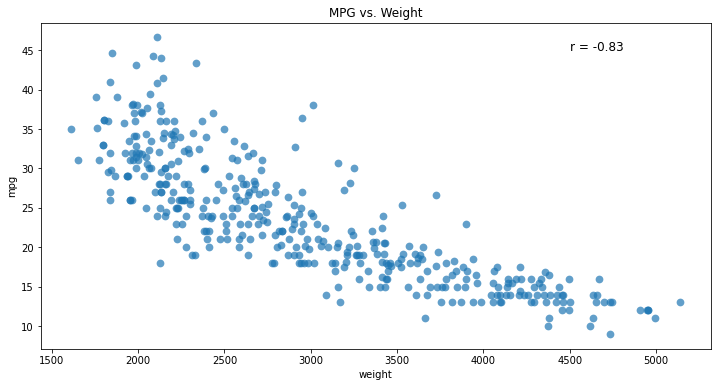

In [ ]:
mpg_vs_weight_corr = mpg_df_corr.loc['mpg','weight']

mpg_clean_df.plot.scatter(
    x='weight',
    y='mpg',
    figsize=(12,6),
    title='MPG vs. Weight',
    lw=False,
    alpha=.7,
    s=60,
)
plt.text(4500, 45, f"r = {round(mpg_vs_weight_corr, 2)}", fontsize=12)
plt.show()


From the figure above, the scatterplot further comfirms that it is likely that MPG and Weight have a strong negative correlation.

***

<br>

## Regression Modeling

### Preprocessing

Create train/test sets.

In [ ]:
train_df, test_df = train_test_split(mpg_clean_df, test_size=0.2, random_state=777)

X_train = train_df.drop(columns=['mpg'])
y_train = train_df['mpg']

X_test = test_df.drop(columns=['mpg'])
y_test = test_df['mpg']


<br>

### OLS Linear Regression

In [ ]:
ols = LinearRegression()

ols.fit(X_train, y_train)

ols_y_train_pred = ols.predict(X_train)
ols_y_test_pred = ols.predict(X_test)


<br>

### Ridge Regression

In [ ]:
ridge = Ridge()

ridge.fit(X_train, y_train)

ridge_y_train_pred = ridge.predict(X_train)
ridge_y_test_pred = ridge.predict(X_test)


### Regression Results

In [ ]:
def get_metrics(y_true, y_pred):
    print(f"R-squared: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred, squared=True)}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

sep_n = 25

# OLS train metrics
print(f"OLS Train Set Metrics\n{'='*sep_n}")
get_metrics(y_train, ols_y_train_pred)
print('\n')

# OLS test metrics
print(f"OLS Test Set Metrics\n{'='*sep_n}")
get_metrics(y_test, ols_y_test_pred)
print('\n')

# Ridge train metrics
print(f"Ridge Train Set Metrics\n{'='*sep_n}")
get_metrics(y_train, ridge_y_train_pred)
print('\n')

# Ridge test metrics
print(f"Ridge Test Set Metrics\n{'='*sep_n}")
get_metrics(y_test, ridge_y_test_pred)


OLS Train Set Metrics
R-squared: 0.8266777990619414
MSE: 10.687895455737225
RMSE: 3.269234689608139
MAE: 2.4784294079952987


OLS Test Set Metrics
R-squared: 0.8046144798153276
MSE: 11.211641227064895
RMSE: 3.34837889538578
MAE: 2.6879778768970586


Ridge Train Set Metrics
R-squared: 0.8266417140247149
MSE: 10.690120635796706
RMSE: 3.2695749931446296
MAE: 2.4778662070368287


Ridge Test Set Metrics
R-squared: 0.8044949672684687
MSE: 11.218499113955641
RMSE: 3.3494027995981077
MAE: 2.6905750047192596


From the analysis, $R^2$ for the OLS model was `0.83` for the training set and `0.80` for the test set. This is an indication that the model can potentially account for roughly 80% of the variation in MPG. 

<br>The $RMSE$ for the testing set was `3.3` indicating that the prediction on average was off by 3.3 MPG. 

<br>The $MAE$ for the testing set was `2.7` which indicates the same thing as $RMSE$ but with less importance given to outliers. If outliers are of great concern then using $RMSE$ may be a better metric.

<br>

